## Story 3: Do stricter gun laws reduce gun deaths?

### Import Libraries

In [30]:
import requests
import pandas as pd
import re
import plotly.express as px
import statsmodels.api as sm
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default='notebook'
from IPython.display import Image

Utilizing the [Soctrata API](https://dev.socrata.com/foundry/data.cdc.gov/489q-934x) to pull in the relevant statistics from the CDC as well as the [Gifford Organization gun law scorecard](https://giffords.org/lawcenter/resources/scorecard/) which provided relevant gun law evaluations for each state and was supplemented by their [evaluation](https://giffords.org/lawcenter/gun-laws/washington-dc/) of DC gun laws.

### Call CDC API for relevant data on firearm deaths

In [31]:
firearm_deaths = requests.get('https://data.cdc.gov/resource/489q-934x.json?cause_of_death=Firearm-related injury')
df = pd.DataFrame.from_records(firearm_deaths.json())
df.columns

Index(['year_and_quarter', 'time_period', 'cause_of_death', 'rate_type',
       'unit', 'rate_overall', 'rate_sex_female', 'rate_sex_male',
       'rate_alaska', 'rate_alabama', 'rate_arkansas', 'rate_arizona',
       'rate_california', 'rate_colorado', 'rate_connecticut',
       'rate_district_of_columbia', 'rate_delaware', 'rate_florida',
       'rate_georgia', 'rate_hawaii', 'rate_iowa', 'rate_idaho',
       'rate_illinois', 'rate_indiana', 'rate_kansas', 'rate_kentucky',
       'rate_louisiana', 'rate_massachusetts', 'rate_maryland', 'rate_maine',
       'rate_michigan', 'rate_minnesota', 'rate_missouri', 'rate_mississippi',
       'rate_montana', 'rate_north_carolina', 'rate_north_dakota',
       'rate_nebraska', 'rate_new_hampshire', 'rate_new_jersey',
       'rate_new_mexico', 'rate_nevada', 'rate_new_york', 'rate_ohio',
       'rate_oklahoma', 'rate_oregon', 'rate_pennsylvania',
       'rate_rhode_island', 'rate_south_carolina', 'rate_south_dakota',
       'rate_tennessee', 'ra

In [32]:
df.groupby(['time_period'])['rate_type'].count()

time_period
12 months ending with quarter    24
3-month period                   24
Name: rate_type, dtype: int64

### Load in Supplemental Files

In [33]:
fips_df = pd.read_csv('https://raw.githubusercontent.com/jforster19/Data608/main/state_fip.csv',dtype={'fips':str})
likert_df = pd.read_csv('https://raw.githubusercontent.com/jforster19/Data608/main/state_law_likert.csv')

In [34]:
fips_df.head()

,state,st_abbr,fips
0,Alabama,AL,01
1,Alaska,AK,02
2,Arizona,AZ,04
3,Arkansas,AR,05
4,California,CA,06


In [35]:
fips_df.dtypes

state      object
st_abbr    object
fips       object
dtype: object

In [36]:
likert_df.head()

,gifford_ranked_law_strength,State,gifford_gun_law_grade,gun_date_rate_rank,gun_death_rate_per100K,gun_law_likert_scale
0,1,California,A,43.0,9.0,Very strict
1,2,New Jersey,A,48.0,5.2,Very strict
2,3,Connecticut,A-,45.0,6.7,Very strict
3,5,Hawaii,A-,49.0,4.8,Very strict
4,8,Illinois,A-,26.0,16.1,Very strict


In [37]:
likert_df.groupby('gun_law_likert_scale')['State'].count()

gun_law_likert_scale
Very strict     8
lax             1
moderate        8
strict          8
very lax       26
Name: State, dtype: int64

In [38]:
likert_df.dtypes

gifford_ranked_law_strength      int64
State                           object
gifford_gun_law_grade           object
gun_date_rate_rank             float64
gun_death_rate_per100K         float64
gun_law_likert_scale            object
dtype: object

In [39]:
likert_num = {'Very strict':1,'very strict':1,'strict':2,'moderate':3,'lax':4,'very lax':5}
likert_df.loc[:,'likert_num'] = likert_df['gun_law_likert_scale'].apply(lambda col: likert_num[col])
likert_df.head(15)

,gifford_ranked_law_strength,State,gifford_gun_law_grade,gun_date_rate_rank,gun_death_rate_per100K,gun_law_likert_scale,likert_num
0,1,California,A,43.0,9.0,Very strict,1
1,2,New Jersey,A,48.0,5.2,Very strict,1
2,3,Connecticut,A-,45.0,6.7,Very strict,1
3,5,Hawaii,A-,49.0,4.8,Very strict,1
4,8,Illinois,A-,26.0,16.1,Very strict,1
5,7,Maryland,A-,29.0,15.2,Very strict,1
6,6,Massachusetts,A-,50.0,3.4,Very strict,1
7,4,New York,A-,47.0,5.4,Very strict,1
8,0,District of Columbia,B+,NaN,NaN,strict,2
9,11,Oregon,B+,30.0,14.9,strict,2


### Data Wrangling

In [40]:
state_supp_df = pd.merge(likert_df,fips_df,left_on='State',right_on='state')

In [41]:
df.head()

,year_and_quarter,time_period,cause_of_death,rate_type,unit,rate_overall,rate_sex_female,rate_sex_male,rate_alaska,rate_alabama,...,rate_age_1_4,rate_age_5_14,rate_age_15_24,rate_age_25_34,rate_age_35_44,rate_age_45_54,rate_age_55_64,rate_65_74,rate_age_75_84,rate_age_85_plus
0,2020 Q1,12 months ending with quarter,Firearm-related injury,Age-adjusted,"Deaths per 100,000",12,3.4,21.1,23,21.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020 Q1,3-month period,Firearm-related injury,Age-adjusted,"Deaths per 100,000",12.1,3.2,21.3,21.4,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020 Q2,12 months ending with quarter,Firearm-related injury,Age-adjusted,"Deaths per 100,000",12.3,3.4,21.6,22.7,22.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020 Q2,3-month period,Firearm-related injury,Age-adjusted,"Deaths per 100,000",13.1,3.7,22.9,20.2,23.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020 Q3,12 months ending with quarter,Firearm-related injury,Age-adjusted,"Deaths per 100,000",13,3.6,22.7,24.5,23.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
annual_df = df[(df['time_period']!='3-month period') & (df['rate_type']=='Crude')]
annual_df.rename(columns={'rate_type':'type'},inplace=True)      

/var/folders/d5/98xjjxvs53s2lf63ml40f_sc0000gn/T/ipykernel_2666/2513935099.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
df_long = pd.melt(annual_df,id_vars=['year_and_quarter', 'time_period', 'cause_of_death', 'type',
       'unit'],var_name='measure_name')
df_states = df_long[~df_long.measure_name.str.contains('\d|overall|sex',regex=True)].copy()
df_states.loc[:,'state'] = df_states['measure_name'].apply(lambda col: col.replace('rate_','').replace('_',' ').title())
df_states.loc[df_states['state']=='District Of Columbia','state'] = 'District of Columbia'
df_states.loc[:,'value_num'] =  pd.to_numeric(df_states['value'])
df_states.head()

,year_and_quarter,time_period,cause_of_death,type,unit,measure_name,value,state,value_num
36,2020 Q1,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,23.4,Alaska,23.4
37,2020 Q2,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,23.3,Alaska,23.3
38,2020 Q3,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,25.3,Alaska,25.3
39,2020 Q4,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,23.9,Alaska,23.9
40,2021 Q1,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,23.1,Alaska,23.1


In [44]:
df_states['value_num'].describe()

count    561.000000
mean      15.677540
std        6.308466
min        3.300000
25%       11.600000
50%       15.300000
75%       20.500000
max       33.000000
Name: value_num, dtype: float64

In [45]:
df_states[(df_states['value_num'].isna())&(~df_states['value'].isna())]

,year_and_quarter,time_period,cause_of_death,type,unit,measure_name,value,state,value_num


In [46]:
df_states.dtypes

year_and_quarter     object
time_period          object
cause_of_death       object
type                 object
unit                 object
measure_name         object
value                object
state                object
value_num           float64
dtype: object

In [47]:
df_states.loc[pd.isna(df_states['value']),:].shape

(51, 9)

In [48]:
df_states['state'].unique()

array(['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'District of Columbia', 'Delaware',
       'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois',
       'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts',
       'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri',
       'Mississippi', 'Montana', 'North Carolina', 'North Dakota',
       'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada',
       'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin',
       'West Virginia', 'Wyoming'], dtype=object)

In [49]:
(len(set(df_states.state)),df_states.shape)

(51, (612, 9))

In [50]:
df_states_final = pd.merge(df_states,state_supp_df,left_on='state',right_on='state',suffixes=[None,'_right'])
df_states_final.loc[:,'gun_law_likert_scale'] = df_states_final['gun_law_likert_scale'].apply(lambda x: x.lower())
df_states_final.head()

,year_and_quarter,time_period,cause_of_death,type,unit,measure_name,value,state,value_num,gifford_ranked_law_strength,State,gifford_gun_law_grade,gun_date_rate_rank,gun_death_rate_per100K,gun_law_likert_scale,likert_num,st_abbr,fips
0,2020 Q1,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,23.4,Alaska,23.4,41,Alaska,F,6.0,25.2,very lax,5,AK,02
1,2020 Q2,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,23.3,Alaska,23.3,41,Alaska,F,6.0,25.2,very lax,5,AK,02
2,2020 Q3,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,25.3,Alaska,25.3,41,Alaska,F,6.0,25.2,very lax,5,AK,02
3,2020 Q4,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,23.9,Alaska,23.9,41,Alaska,F,6.0,25.2,very lax,5,AK,02
4,2021 Q1,12 months ending with quarter,Firearm-related injury,Crude,"Deaths per 100,000",rate_alaska,23.1,Alaska,23.1,41,Alaska,F,6.0,25.2,very lax,5,AK,02


In [51]:
df_states_final.shape

(612, 18)

Story -3 : Do stricter gun laws reduce firearm gun deaths?
The CDC publishes firearm mortality for each State per 100,000 persons https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm. Each State' firearm control laws can be categorized as very strict to very lax. The purpose of this Story is to answer the question, " Do stricter firearm control laws help reduce firearm mortality?"
For this assignment you will need to:
Access the firearm mortality data from the CDC using an available API (https://open.cdc.gov/apis.html)

Create a 5 point Likert scale categorizing gun control laws from most lax to strictest and assign each state to the most appropriate Likert bin.

Determine wether stricter gun control laws result in reduced gun violence deaths

Present your story using  heat maps
Notes:
You may not use the same desktop application that you have used for a previous story.

If you use color in your visuals you must use an accessible color palette. 

##### Reviewing Plotly available color palettes

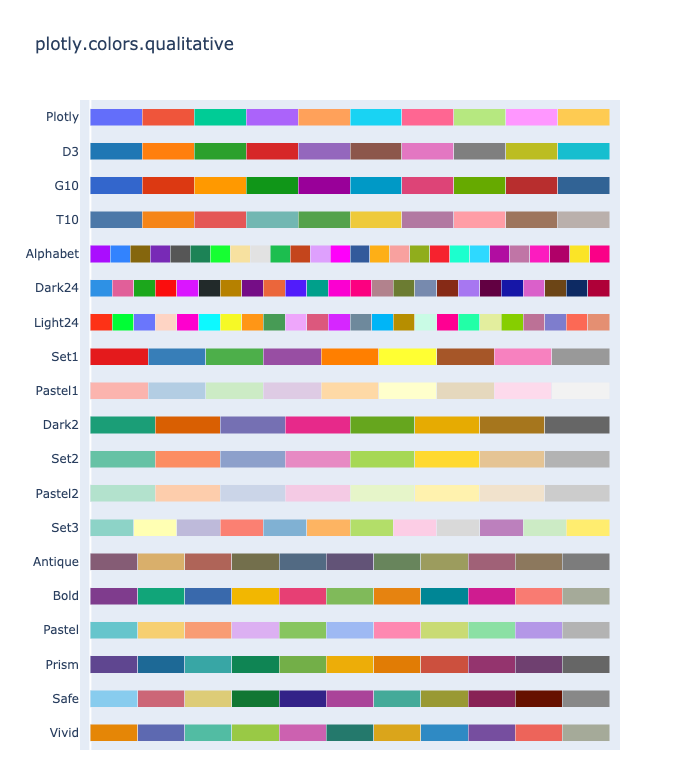

In [52]:
fig = px.colors.qualitative.swatches()
fig_bytes = fig.to_image(format="png")
Image(fig_bytes)

In [53]:
viz_df = df_states_final[(df_states_final['year_and_quarter'].str.contains('Q4')) & (df_states_final['year_and_quarter'].str.contains('2021'))]
viz_all_years_df = df_states_final[(df_states_final['year_and_quarter'].str.contains('Q3'))]
viz_all_years_df.loc[:,'Year'] = viz_all_years_df['year_and_quarter'].apply(lambda x: x[0:4])
#viz_all_years_df.groupby('Year')['type'].count()

/var/folders/d5/98xjjxvs53s2lf63ml40f_sc0000gn/T/ipykernel_2666/614798058.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



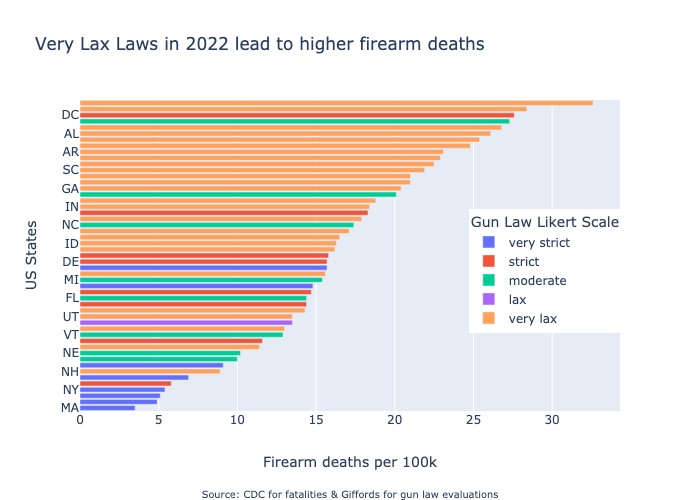

In [72]:
fig_bar = px.bar(viz_df,
                 x='value_num',y='st_abbr',
                 color='gun_law_likert_scale',title='Very Lax Laws in 2022 lead to higher firearm deaths',
                # color_discrete_sequence=px.colors.qualitative.D3,
                category_orders={'gun_law_likert_scale':['very strict','strict','moderate','lax','very lax']})
fig_bar.update_layout(yaxis={'categoryorder':'total ascending','title':'US States'},
                      xaxis={'title':'Firearm deaths per 100k<br><br><sup>Source: CDC for fatalities & Giffords for gun law evaluations<sup>'},
                      legend=dict(x=0.72,y=0.25,title='Gun Law Likert Scale')) 
fig_bar_img = fig_bar.to_image(format="png")
Image(fig_bar_img)

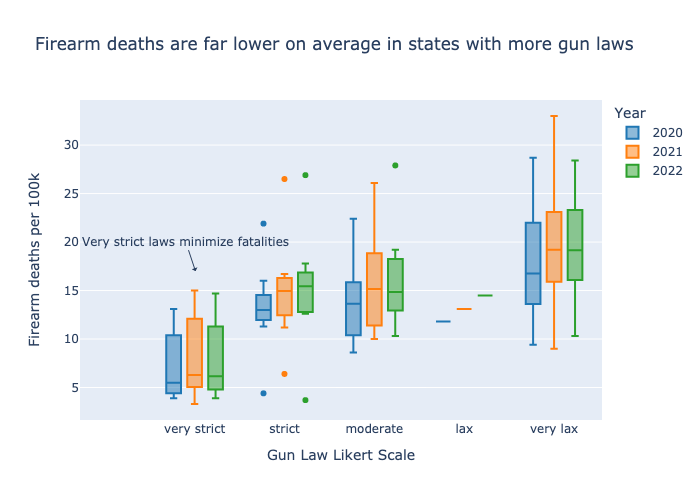

In [62]:
fig_box = px.box(viz_all_years_df,x='gun_law_likert_scale',y='value_num',color='Year',
       labels={"value_num": "Firearm deaths per 100k",
               "gun_law_likert_scale": "Gun Law Likert Scale",'year_and_quarter':'Year'},
       color_discrete_sequence=px.colors.qualitative.D3,
       title='Firearm deaths are far lower on average in states with more gun laws',
      category_orders={'gun_law_likert_scale':['very strict','strict','moderate','lax','very lax']})
fig_box.add_annotation(x=0.01, y=17,
            text="Very strict laws minimize fatalities",
            showarrow=True,
            arrowhead=1)
fig_box_img = fig_box.to_image(format="png")
Image(fig_box_img)

In [71]:
fig_heat_map = px.density_heatmap(viz_df,x='state',y='gun_law_likert_scale',z='value_num',
                                  title='Firearm deaths are far more concentrated in states with more lax laws',
                   color_continuous_scale=px.colors.sequential.Blues,
                  category_orders={'gun_law_likert_scale':['very strict','strict','moderate','lax','very lax'],'value_num':'Firearm deaths per 100k'})
fig_heat_map.update_layout(font_size=9,yaxis_title='Gun Laws Likert Scale',xaxis_title='<sup>Source: CDC for fatalities & Giffords for gun law evaluations<sup>',
                           coloraxis_colorbar_title_text='Firearm deaths per 100k')
                           #legend_title_text='Firearm deaths per 100k')
fig_heat_map.show()

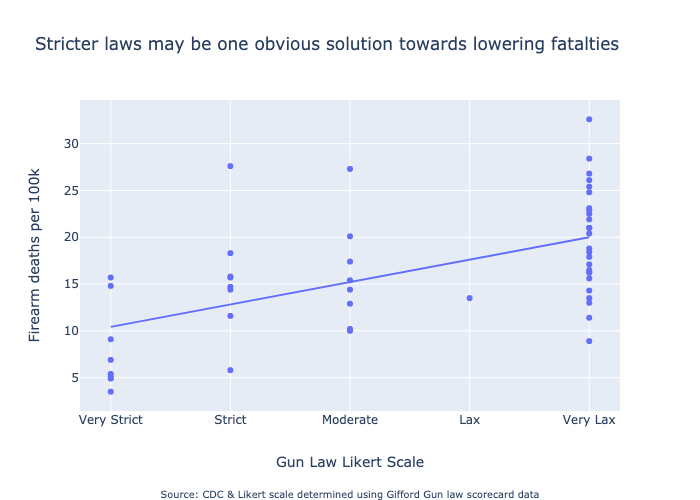

In [70]:
fig_scat = px.scatter(viz_df,x=['likert_num'],y='value_num',
                      #color='gun_law_likert_scale',
                      #color_discrete_sequence=px.colors.qualitative.D3,
                      labels='st_abbr', trendline="ols",title='Stricter laws may be one obvious solution towards lowering fatalties')
fig_scat.update_layout(yaxis_title='Firearm deaths per 100k',
                       xaxis_title='Gun Law Likert Scale<br><br><sup>Source: CDC & Likert scale determined using Gifford Gun law scorecard data</sup>',
                       xaxis=dict(tickmode = 'array',
        tickvals = [1, 2, 3, 4, 5],
        ticktext = ['Very Strict', 'Strict', 'Moderate', 'Lax', 'Very Lax']),
                      showlegend=False)
fig_scat_img = fig_scat.to_image(format="png")
Image(fig_scat_img)